# Crime Data Exploration

This notebook contains initial data exploration on the crime data available from the London data store. The focus is trends across time, and whether all types of offences follow the same pattern.  Creating cleaned data sets for analysis and map based visualisations is covered in a later note book.

**Import libraries**

In [2]:
try:
    print("Importing libraries...\n")
    from progressbar import ProgressBar
    from bs4 import BeautifulSoup as bts # library for web scraping
    import numpy as np # library to handle data in a vectorized manner
    import pandas as pd # library for data analysis
    from pandas.io.json import json_normalize
    import matplotlib.cm as cm
    import matplotlib.colors as colors
    import requests # library to handle requests
    from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
    import matplotlib as mp # library for visualization
    from sklearn.cluster import KMeans # import k-means from clustering stage
    from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
    import folium # map rendering library
    import lxml
    import re
    from time import sleep
    
    from matplotlib import pyplot as plt
    from matplotlib.pyplot import figure
    
    import datetime
    import dateutil
    
    from datetime import datetime as dt
    print("All libraries imported successfully!\n")
except:
    print("ERROR: Could not import all libraries!\n")

%matplotlib inline

Importing libraries...

All libraries imported successfully!



##  London Crime Data

Crime data for London can be sourced from the UK government London data store. This covers areas served by the metropolitan police service which is all London boroughs, but excludes the city of london (also known as "the square mile" -  a central financial district).   

First look at the most recent data recorded by borough

In [3]:
crime = pd.read_csv('https://data.london.gov.uk/download/recorded_crime_summary/d2e9ccfc-a054-41e3-89fb-53c2bc3ed87a/MPS%20Borough%20Level%20Crime%20%28most%20recent%2024%20months%29.csv')
crime.head()

,MajorText,MinorText,LookUp_BoroughName,201905,201906,201907,201908,201909,201910,201911,...,202007,202008,202009,202010,202011,202012,202101,202102,202103,202104
0,Arson and Criminal Damage,Arson,Barking and Dagenham,11,3,5,3,6,9,8,...,4,6,2,7,4,2,4,6,4,6
1,Arson and Criminal Damage,Criminal Damage,Barking and Dagenham,140,113,134,118,109,109,97,...,122,114,116,120,100,109,100,104,80,100
2,Burglary,Burglary - Business and Community,Barking and Dagenham,21,27,31,35,37,30,30,...,28,23,32,21,18,24,20,18,14,12
3,Burglary,Burglary - Residential,Barking and Dagenham,114,96,71,67,80,97,114,...,72,63,54,68,90,91,69,90,71,75
4,Drug Offences,Drug Trafficking,Barking and Dagenham,9,6,11,8,7,9,14,...,21,9,12,13,17,13,12,9,7,6


In [4]:
crime.shape

(1547, 27)

Rename the Borough column

In [5]:
crime.rename(columns={'LookUp_BoroughName':'Borough'}, inplace=True)

Ths data shows monthly crimes per borough,  categorised into major classifications, then subcategorised to minor sub classifications. The full set of  crime types is:

In [6]:
crime[['MajorText', 'MinorText']].drop_duplicates().sort_values(['MajorText']).reset_index().drop(['index'], axis=1)

,MajorText,MinorText
0,Arson and Criminal Damage,Arson
1,Arson and Criminal Damage,Criminal Damage
2,Burglary,Burglary - Business and Community
3,Burglary,Burglary - Residential
4,Drug Offences,Drug Trafficking
5,Drug Offences,Possession of Drugs
6,Miscellaneous Crimes Against Society,Aiding Suicide
7,Miscellaneous Crimes Against Society,Offender Management Act
8,Miscellaneous Crimes Against Society,Soliciting for Prostitution
9,Miscellaneous Crimes Against Society,Wildlife Crime


## Crime trends over last 24 months

Explore the trend of drug offences over the 24 months, with consideration to the different (major) crime classifications to ascertain the approach to using this data.

In [7]:

majorCrimeSeries=crime.drop('MinorText', 1)
majorCrimeSeries.rename(columns={'MajorText':'Crime Classification'}, inplace=True)
majorCrimeSeries.head()

,Crime Classification,Borough,201905,201906,201907,201908,201909,201910,201911,201912,...,202007,202008,202009,202010,202011,202012,202101,202102,202103,202104
0,Arson and Criminal Damage,Barking and Dagenham,11,3,5,3,6,9,8,6,...,4,6,2,7,4,2,4,6,4,6
1,Arson and Criminal Damage,Barking and Dagenham,140,113,134,118,109,109,97,122,...,122,114,116,120,100,109,100,104,80,100
2,Burglary,Barking and Dagenham,21,27,31,35,37,30,30,26,...,28,23,32,21,18,24,20,18,14,12
3,Burglary,Barking and Dagenham,114,96,71,67,80,97,114,130,...,72,63,54,68,90,91,69,90,71,75
4,Drug Offences,Barking and Dagenham,9,6,11,8,7,9,14,3,...,21,9,12,13,17,13,12,9,7,6


In [8]:
majorCrimeSeries = majorCrimeSeries.groupby(['Crime Classification']).sum()
majorCrimeSeries.head()

,201905,201906,201907,201908,201909,201910,201911,201912,202001,202002,...,202007,202008,202009,202010,202011,202012,202101,202102,202103,202104
Crime Classification,,,,,,,,,,,,,,,,,,,,,
Arson and Criminal Damage,4901,4715,4931,4601,4580,4887,4580,4557,4426,4348,...,4712,4714,4332,4351,4192,4063,3636,3544,4201,4275
Burglary,6412,6371,6313,6164,6527,7294,7099,6836,6992,6301,...,4959,5005,5202,5660,5221,4758,4289,4067,4711,4204
Drug Offences,3922,4098,4570,4854,3999,3988,4046,3493,4708,4211,...,4935,3827,3803,4355,4652,3836,3900,4231,4300,3801
Miscellaneous Crimes Against Society,1045,947,994,898,953,982,993,895,971,872,...,993,888,1088,934,1099,893,854,871,1145,1020
Possession of Weapons,634,562,583,618,563,603,562,537,699,528,...,538,531,574,569,577,448,421,426,428,338


In [9]:
majorCrimeSeries=majorCrimeSeries.transpose()
majorCrimeSeries.head()

Crime Classification,Arson and Criminal Damage,Burglary,Drug Offences,Miscellaneous Crimes Against Society,Possession of Weapons,Public Order Offences,Robbery,Sexual Offences,Theft,Vehicle Offences,Violence Against the Person
201905,4901,6412,3922,1045,634,4583,3331,1702,21878,10076,18895
201906,4715,6371,4098,947,562,4654,3174,1828,21280,10066,19057
201907,4931,6313,4570,994,583,5305,3428,1855,22917,10539,20326
201908,4601,6164,4854,898,618,4687,3083,1556,21055,10498,18644
201909,4580,6527,3999,953,563,4485,3352,1607,20013,11633,18486


In [10]:
majorCrimeSeries.index = majorCrimeSeries.index + "01"
majorCrimeSeries.head()

Crime Classification,Arson and Criminal Damage,Burglary,Drug Offences,Miscellaneous Crimes Against Society,Possession of Weapons,Public Order Offences,Robbery,Sexual Offences,Theft,Vehicle Offences,Violence Against the Person
20190501,4901,6412,3922,1045,634,4583,3331,1702,21878,10076,18895
20190601,4715,6371,4098,947,562,4654,3174,1828,21280,10066,19057
20190701,4931,6313,4570,994,583,5305,3428,1855,22917,10539,20326
20190801,4601,6164,4854,898,618,4687,3083,1556,21055,10498,18644
20190901,4580,6527,3999,953,563,4485,3352,1607,20013,11633,18486


In [11]:
majorCrimeSeries.index = pd.to_datetime(majorCrimeSeries.index,yearfirst=True) #format('%Y%m%d'), errors='ignore')

In [12]:
majorCrimeSeries.head()

Crime Classification,Arson and Criminal Damage,Burglary,Drug Offences,Miscellaneous Crimes Against Society,Possession of Weapons,Public Order Offences,Robbery,Sexual Offences,Theft,Vehicle Offences,Violence Against the Person
2019-05-01,4901,6412,3922,1045,634,4583,3331,1702,21878,10076,18895
2019-06-01,4715,6371,4098,947,562,4654,3174,1828,21280,10066,19057
2019-07-01,4931,6313,4570,994,583,5305,3428,1855,22917,10539,20326
2019-08-01,4601,6164,4854,898,618,4687,3083,1556,21055,10498,18644
2019-09-01,4580,6527,3999,953,563,4485,3352,1607,20013,11633,18486


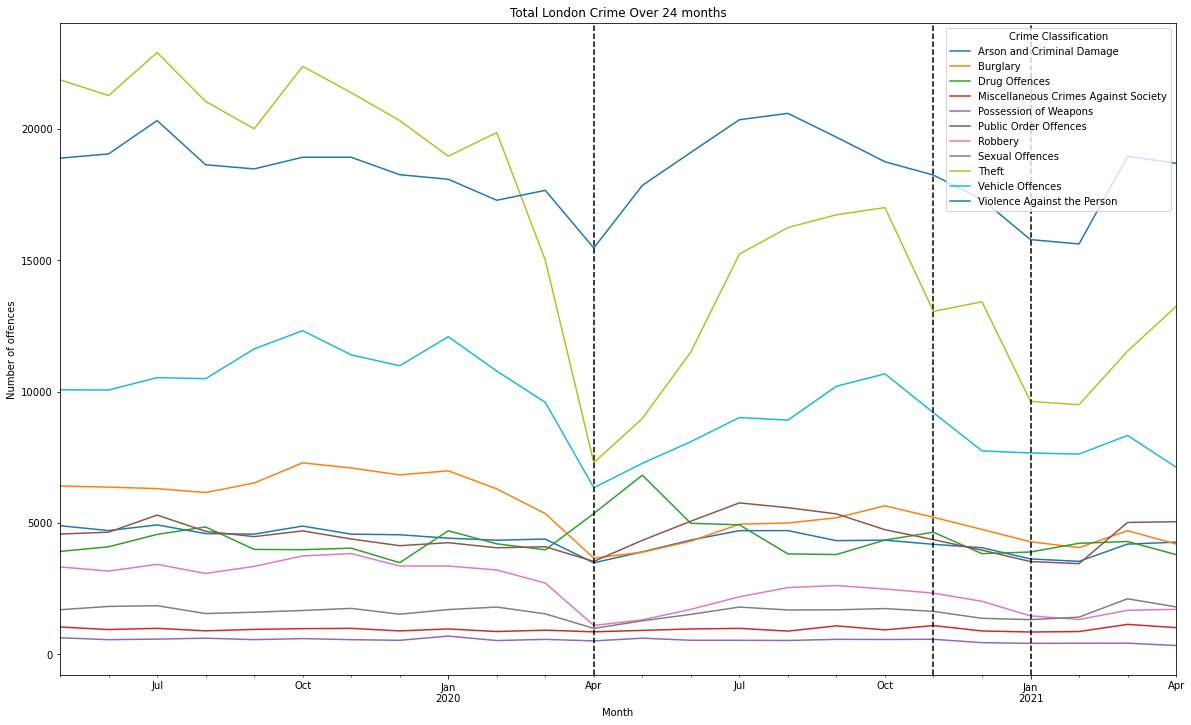

In [13]:
plt.rcParams["figure.figsize"] = (20,12)
majorCrimeSeries.plot(kind='line')
plt.title("Total London Crime Over 24 months")
plt.xlabel("Month")
plt.ylabel("Number of offences")

xposition = [dt.strptime('01-Apr-2020', '%d-%b-%Y'),dt.strptime('01-Nov-2020', '%d-%b-%Y'),dt.strptime('01-Jan-2021', '%d-%b-%Y')]# ['202004', '202011', '202101']
for xc in xposition:
    plt.axvline(x=xc, color='k', linestyle='--')
plt.savefig("24monthcrimeseries.png")

**Observation:** This indicates that
a) Crime trends have been influenced by the Covid 19 pandemic
b) Not all crimes follow the same trend.  For example poessision of weapon has been consistent throughout the time frame, drugs offences increased with the initial lockdown whereas most crimes dropped


**Conclusions:**
Therefore, the purposes of this analysis the following approach will be taken
1. Total crime over the 24 month period will be considered
2. Different classifications of crime will be considered

## Create 2 year crime totals

Create list of month columns and then sum across them

In [14]:
date_list=[datetime.date.today()- dateutil.relativedelta.relativedelta(months = x) for x in range(25,1,-1)]
month_list=[datetime.date.strftime(x,'%Y%m') for x in date_list]
month_list

['201905',
 '201906',
 '201907',
 '201908',
 '201909',
 '201910',
 '201911',
 '201912',
 '202001',
 '202002',
 '202003',
 '202004',
 '202005',
 '202006',
 '202007',
 '202008',
 '202009',
 '202010',
 '202011',
 '202012',
 '202101',
 '202102',
 '202103',
 '202104']

In [15]:
crime['Total Crime'] = 0

for month in month_list:
    crime['Total Crime'] = crime['Total Crime']+crime[month]
crime.head()

,MajorText,MinorText,Borough,201905,201906,201907,201908,201909,201910,201911,...,202008,202009,202010,202011,202012,202101,202102,202103,202104,Total Crime
0,Arson and Criminal Damage,Arson,Barking and Dagenham,11,3,5,3,6,9,8,...,6,2,7,4,2,4,6,4,6,119
1,Arson and Criminal Damage,Criminal Damage,Barking and Dagenham,140,113,134,118,109,109,97,...,114,116,120,100,109,100,104,80,100,2601
2,Burglary,Burglary - Business and Community,Barking and Dagenham,21,27,31,35,37,30,30,...,23,32,21,18,24,20,18,14,12,584
3,Burglary,Burglary - Residential,Barking and Dagenham,114,96,71,67,80,97,114,...,63,54,68,90,91,69,90,71,75,2010
4,Drug Offences,Drug Trafficking,Barking and Dagenham,9,6,11,8,7,9,14,...,9,12,13,17,13,12,9,7,6,256


## Drug Crime Data Exploration

Drug offences is used as an example to explore if trends vary across subclassifications of a major classification

### Extract Subclassification Level Data

> Filter on major classification

In [16]:
drugCrime = crime[crime['MajorText']=='Drug Offences']
drugCrime.head()

,MajorText,MinorText,Borough,201905,201906,201907,201908,201909,201910,201911,...,202008,202009,202010,202011,202012,202101,202102,202103,202104,Total Crime
4,Drug Offences,Drug Trafficking,Barking and Dagenham,9,6,11,8,7,9,14,...,9,12,13,17,13,12,9,7,6,256
5,Drug Offences,Possession of Drugs,Barking and Dagenham,87,100,92,74,83,89,95,...,83,95,144,132,102,81,126,146,127,2686
52,Drug Offences,Drug Trafficking,Barnet,8,9,8,12,8,11,12,...,11,17,14,12,9,7,11,14,8,252
53,Drug Offences,Possession of Drugs,Barnet,51,69,68,90,57,52,63,...,108,55,80,97,89,65,77,86,79,1858
97,Drug Offences,Drug Trafficking,Bexley,2,3,5,1,3,2,1,...,7,3,25,3,9,1,3,7,3,103


### Distribution across boroughs

>Rename "MinorText" to the more meaningful "Offence Subclassification"
>Pivot data to view totals for each  subclassification across each borough

In [18]:
drugCrimeByBorough = pd.pivot_table(drugCrime.rename(columns={'MinorText':'Offence Subclassification'}), values='Total Crime', index = ['Borough'], columns='Offence Subclassification').reset_index()
drugCrimeByBorough.set_index(['Borough'], inplace=True)
drugCrimeByBorough.head()

Offence Subclassification,Drug Trafficking,Possession of Drugs
Borough,,
Barking and Dagenham,256,2686
Barnet,252,1858
Bexley,103,1542
Brent,258,3948
Bromley,132,2274


>Plot

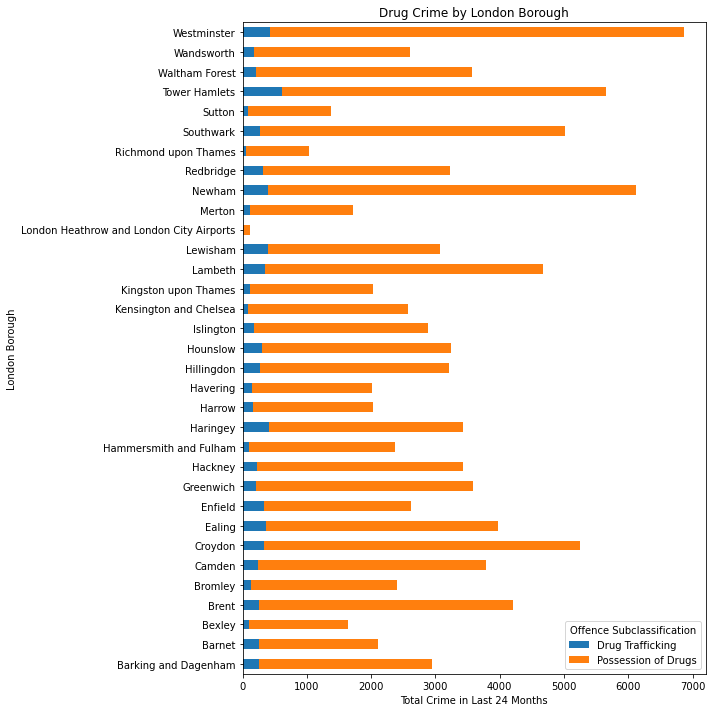

In [25]:
plt.rcParams["figure.figsize"] = (10,10)
drugCrimeByBorough.plot(kind='barh', stacked=True)
plt.title("Drug Crime by London Borough")
plt.xlabel("Total Crime in Last 24 Months")
plt.ylabel("London Borough")
plt.tight_layout()
plt.savefig("DrugCrimeByBorough.png")

 This shows that the two subclassifications of drug offences follow different trends to the major classification.**Observation:** This shows that the two subclassifications of drug offences follow different trends to the major classification.

**Conclusion** Offence subclassification should be considered with in the analysis

Consider the trend of drug offences over the 24 months

In [21]:
drugCrimeSeries=drugCrime.drop(['Total Crime','MajorText'], axis=1)
drugCrimeSeries.rename(columns={'MinorText':'Offence Subclassification'}, inplace=True)
drugCrimeSeries.head()

,Offence Subclassification,Borough,201905,201906,201907,201908,201909,201910,201911,201912,...,202007,202008,202009,202010,202011,202012,202101,202102,202103,202104
4,Drug Trafficking,Barking and Dagenham,9,6,11,8,7,9,14,3,...,21,9,12,13,17,13,12,9,7,6
5,Possession of Drugs,Barking and Dagenham,87,100,92,74,83,89,95,79,...,117,83,95,144,132,102,81,126,146,127
52,Drug Trafficking,Barnet,8,9,8,12,8,11,12,6,...,16,11,17,14,12,9,7,11,14,8
53,Possession of Drugs,Barnet,51,69,68,90,57,52,63,44,...,99,108,55,80,97,89,65,77,86,79
97,Drug Trafficking,Bexley,2,3,5,1,3,2,1,5,...,2,7,3,25,3,9,1,3,7,3


In [22]:
drugCrimeSeriesByType = drugCrimeSeries.groupby(['Offence Subclassification']).sum()
drugCrimeSeriesByType

,201905,201906,201907,201908,201909,201910,201911,201912,202001,202002,...,202007,202008,202009,202010,202011,202012,202101,202102,202103,202104
Offence Subclassification,,,,,,,,,,,,,,,,,,,,,
Drug Trafficking,298,262,313,344,224,332,285,224,300,308,...,537,360,435,353,389,281,298,287,274,235
Possession of Drugs,3624,3836,4257,4510,3775,3656,3761,3269,4408,3903,...,4398,3467,3368,4002,4263,3555,3602,3944,4026,3566


In [23]:
drugCrimeSeriesByType=drugCrimeSeriesByType.transpose()
drugCrimeSeriesByType

Offence Subclassification,Drug Trafficking,Possession of Drugs
201905,298,3624
201906,262,3836
201907,313,4257
201908,344,4510
201909,224,3775
201910,332,3656
201911,285,3761
201912,224,3269
202001,300,4408
202002,308,3903


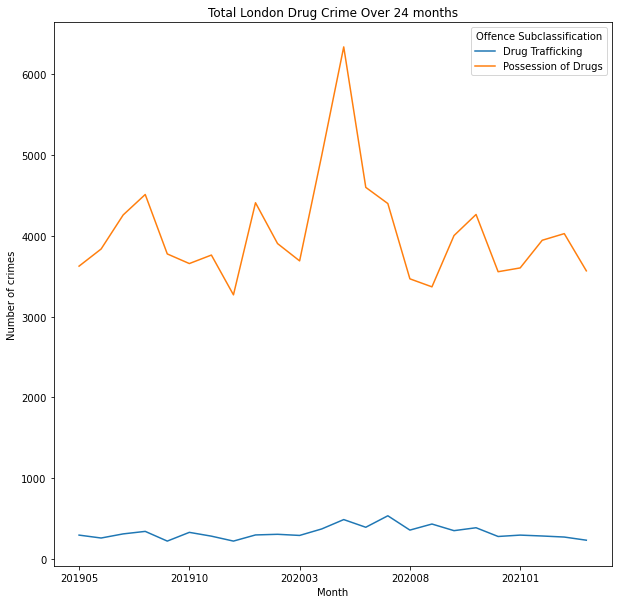

In [24]:
plt.rcParams["figure.figsize"] = (10,10)
drugCrimeSeriesByType.plot(kind='line')
plt.title("Total London Drug Crime Over 24 months")
plt.xlabel("Month")
plt.ylabel("Number of crimes")
plt.savefig("24monthdrugcrimeseries.png")

**Observation**  The offence of posession followed a different pattern over the 24 month period to the offence of traficking.

## Freqency of Minor Crime Categorisations

Consider how much each minor categorisation has occured each month

In [27]:
crime_grouped = crime.groupby(['MinorText']).sum()

In [28]:
crime_grouped

,201905,201906,201907,201908,201909,201910,201911,201912,202001,202002,...,202008,202009,202010,202011,202012,202101,202102,202103,202104,Total Crime
MinorText,,,,,,,,,,,,,,,,,,,,,
Absconding from Lawful Custody,4,2,10,5,3,8,5,4,12,3,...,1,2,3,2,2,1,3,0,3,82
Aggravated Vehicle Taking,98,105,94,115,85,108,84,98,94,76,...,75,88,93,72,57,50,56,57,54,1925
Aiding Suicide,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,2
Arson,186,149,182,177,206,166,168,143,138,135,...,170,140,142,170,113,95,148,136,176,3726
Bail Offences,4,12,8,16,11,15,10,13,14,9,...,2,2,2,2,2,5,0,0,1,152
Bicycle Theft,1965,2002,2377,2042,2004,1731,1341,1024,1193,1097,...,3035,3128,2704,1990,1310,1059,1107,1619,1844,43919
Bigamy,1,0,2,1,1,2,1,2,1,0,...,0,0,1,3,0,1,0,2,0,25
Burglary - Business and Community,1816,1877,1803,1747,1668,1826,1668,1550,1750,1595,...,1052,1189,1275,1042,984,1059,998,1051,1049,32777
Burglary - Residential,4596,4494,4510,4417,4859,5468,5431,5286,5242,4706,...,3953,4013,4385,4179,3774,3230,3069,3660,3155,98839


Consider which crime categories have occured over 1000 times in two years

In [30]:
crime_grouped_freq = crime_grouped[crime_grouped['Total Crime']>1000]
crime_grouped_freq

,201905,201906,201907,201908,201909,201910,201911,201912,202001,202002,...,202008,202009,202010,202011,202012,202101,202102,202103,202104,Total Crime
MinorText,,,,,,,,,,,,,,,,,,,,,
Aggravated Vehicle Taking,98,105,94,115,85,108,84,98,94,76,...,75,88,93,72,57,50,56,57,54,1925
Arson,186,149,182,177,206,166,168,143,138,135,...,170,140,142,170,113,95,148,136,176,3726
Bicycle Theft,1965,2002,2377,2042,2004,1731,1341,1024,1193,1097,...,3035,3128,2704,1990,1310,1059,1107,1619,1844,43919
Burglary - Business and Community,1816,1877,1803,1747,1668,1826,1668,1550,1750,1595,...,1052,1189,1275,1042,984,1059,998,1051,1049,32777
Burglary - Residential,4596,4494,4510,4417,4859,5468,5431,5286,5242,4706,...,3953,4013,4385,4179,3774,3230,3069,3660,3155,98839
Criminal Damage,4715,4566,4749,4424,4374,4721,4412,4414,4288,4213,...,4544,4192,4209,4022,3950,3541,3396,4065,4099,100963
Drug Trafficking,298,262,313,344,224,332,285,224,300,308,...,360,435,353,389,281,298,287,274,235,7892
Going Equipped for Stealing,47,39,46,44,52,49,52,40,45,51,...,32,44,49,42,31,29,32,32,29,1023
Handling Stolen Goods,68,43,90,62,46,63,68,47,65,54,...,36,58,48,59,47,37,37,53,42,1392


Look at which crimes have occured less than 1000 times over two years

In [31]:
crime_grouped[crime_grouped['Total Crime']<1000]

,201905,201906,201907,201908,201909,201910,201911,201912,202001,202002,...,202008,202009,202010,202011,202012,202101,202102,202103,202104,Total Crime
MinorText,,,,,,,,,,,,,,,,,,,,,
Absconding from Lawful Custody,4,2,10,5,3,8,5,4,12,3,...,1,2,3,2,2,1,3,0,3,82
Aiding Suicide,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,2
Bail Offences,4,12,8,16,11,15,10,13,14,9,...,2,2,2,2,2,5,0,0,1,152
Bigamy,1,0,2,1,1,2,1,2,1,0,...,0,0,1,3,0,1,0,2,0,25
Dangerous Driving,36,25,31,25,28,34,24,32,38,30,...,33,49,36,22,30,25,27,22,16,795
"Disclosure, Obstruction, False or Misleading State",5,1,5,2,1,7,9,2,8,5,...,2,2,2,4,5,4,2,4,3,85
Exploitation of Prostitution,0,1,1,1,2,4,6,3,1,4,...,0,4,3,4,2,6,0,0,3,47
Forgery or Use of Drug Prescription,2,6,5,3,1,4,6,8,5,5,...,7,7,3,2,2,3,5,7,7,95
Fraud or Forgery Associated with Driver Records,8,10,11,13,12,9,6,3,8,9,...,3,3,9,8,5,10,12,10,3,171


## Ward and Borough Level Crime Data

Crime data is available at both borough and ward level, as can be seen below the ward level data is very similar to borough level.  See "Data Exploration Crime and Geography" for more detail.    

In [33]:
#get crime data
wardCrime = pd.read_csv('https://data.london.gov.uk/download/recorded_crime_summary/866c05de-c5cd-454b-8fe5-9e7c77ea2313/MPS%20Ward%20Level%20Crime%20%28most%20recent%2024%20months%29.csv')
wardCrime.head()

,MajorText,MinorText,WardName,WardCode,LookUp_BoroughName,201906,201907,201908,201909,201910,...,202008,202009,202010,202011,202012,202101,202102,202103,202104,202105
0,Arson and Criminal Damage,Arson,Abbey,E05000026,Barking and Dagenham,0,0,0,0,2,...,0,0,0,0,0,1,0,0,3,0
1,Arson and Criminal Damage,Criminal Damage,Abbey,E05000026,Barking and Dagenham,11,11,13,10,12,...,14,17,15,17,12,14,4,10,5,25
2,Burglary,Burglary - Business and Community,Abbey,E05000026,Barking and Dagenham,7,7,10,2,4,...,0,1,2,1,5,3,1,3,2,4
3,Burglary,Burglary - Residential,Abbey,E05000026,Barking and Dagenham,6,0,5,6,7,...,7,4,4,7,9,3,4,3,7,2
4,Drug Offences,Drug Trafficking,Abbey,E05000026,Barking and Dagenham,0,3,0,0,1,...,1,0,0,0,0,0,2,1,1,0


## Historic Crime Data

Historic crime data is also available, no additional data exploration conducted as the format is similar to most recent 24 month data.  This is considered appropriate to use if the comparison data is stale, so datewise the comparison is like for like.

In [34]:
historicCrime = pd.read_csv('https://data.london.gov.uk/download/recorded_crime_summary/2bbd58c7-6be6-40ac-99ed-38c0ee411c8e/MPS_Borough_Level_Crime_Historic.csv')
historicCrime.head()

,Borough,Major Category,Minor Category,200801,200802,200803,200804,200805,200806,200807,...,201803,201804,201805,201806,201807,201808,201809,201810,201811,201812
0,Barking and Dagenham,Burglary,Burglary in a Dwelling,82,71,87,74,74,103,113,...,122,75,93,77,94,84,99,94,106,163
1,Barking and Dagenham,Burglary,Burglary in Other Buildings,59,68,56,53,57,39,44,...,61,65,39,52,40,36,50,61,60,50
2,Barking and Dagenham,Criminal Damage,Criminal Damage To Dwelling,79,52,55,73,63,80,73,...,30,29,32,29,21,29,23,35,21,15
3,Barking and Dagenham,Criminal Damage,Criminal Damage To Motor Vehicle,142,138,118,158,126,96,116,...,53,64,64,67,69,42,38,42,47,33
4,Barking and Dagenham,Criminal Damage,Criminal Damage To Other Building,20,19,20,23,16,12,17,...,6,9,8,8,7,7,11,5,4,7


# Create Cleaned and Transformed Datasets for Analysis

see separate notebook